In [ ]:
# Bot check

# HW_ID: phds_hw13
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install dowhy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.4/398.4 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 67.3 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.11
    Uninstalling Cython-3.0.11:
      Successfully uninstalled Cython-3.0.11


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import networkx as nx
from dowhy import gcm

from dowhy import CausalModel
import dowhy.datasets

import networkx as nx
from IPython.display import Image, display

import warnings
warnings.filterwarnings("ignore")

options = {
    "font_size": 14,
    "node_size": 1500,
    "node_color": "#99FF99",
    "edge_color": "#9999FF",
    "arrowsize": 25,
    "width": 3,
}

def draw_graph(graphs, options):
    nx.draw_networkx(graphs, **options)
    ax = plt.gca()
    ax.margins(0.20)
    plt.axis("off")

sns.set(style='whitegrid', palette='Set2')

## Задача 1

Загрузите <a href="https://github.com/robjellis/lalonde">данные</a> об исследовании влияния эффективности программы профессиональной переподготовки по отношению к реальному заработку человека через пару лет после завершения программы (в 1978). Данные также содержат несколько демографических показателей &mdash; возраст, раса, академическое образование и предыдущий заработок.

По аналогии с задачей 2 семинара 13 для имеющихся данных постройте граф причинно-следственных связей и оцените величину эффекта (и ее статистическую значимость) через ATE и ATT с помощью Propensity score, например, используя его как веса таргета (weighting) или как меру похожести при подборе тестовой группы (matching).

Описание параметров датасета:
- `treat` &mdash; были ли пройдена программа профессиональной переподготовки (1 = тестовая группа, 0 = контроль).
- `age` &mdash; возраст.
- `educ` &mdash; количество лет обучения.
- `black` &mdash; обозначение расы (1 = афроамериканец, 0 = нет).
- `hispan` &mdash; латиноамериканского происхождения (1 = да, 0 = нет).
- `married` &mdash; семейное положение (1 = женат/замужем, 0 = неженат/незамужем).
- `nodegree` &mdash; есть ли высшее образование (1 = да, 0 = нет).
- `re74` &mdash; доход в 1974 году в долларах США.
- `re75` &mdash; доход в 1975 году в долларах США.
- `re78` &mdash; доход в 1978 году в долларах США.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/data/lalonde_data.csv', index_col=0)
data.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
ID,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [ ]:
data.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [ ]:
T = 'treat'  # переменная treatment
Y = 're78'  # целевая переменная
X = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']  # список кофаундереов

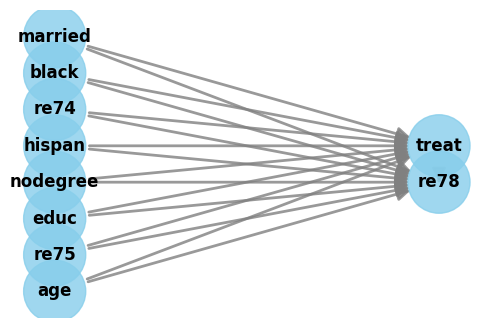

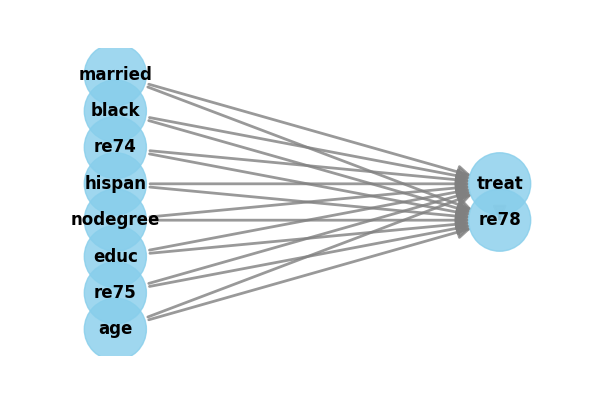

In [ ]:
model = CausalModel(
    data=data,
    treatment=T,
    outcome=Y,
    common_causes=X
)

model.view_model(file_name="causal_model", size=(6, 4))
display(Image(filename="causal_model.png"))

In [ ]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                              
────────(E[re78|age,re75,educ,nodegree,hispan,re74,black,married])
d[treat]                                                          
Estimand assumption 1, Unconfoundedness: If U→{treat} and U→re78 then P(re78|treat,age,re75,educ,nodegree,hispan,re74,black,married,U) = P(re78|treat,age,re75,educ,nodegree,hispan,re74,black,married)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [ ]:
estimate_ate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_weighting",
    target_units="ate",
    treatment_value=1,
    control_value=0
)

In [ ]:
print(estimate_ate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                              
────────(E[re78|age,re75,educ,nodegree,hispan,re74,black,married])
d[treat]                                                          
Estimand assumption 1, Unconfoundedness: If U→{treat} and U→re78 then P(re78|treat,age,re75,educ,nodegree,hispan,re74,black,married,U) = P(re78|treat,age,re75,educ,nodegree,hispan,re74,black,married)

## Realized estimand
b: re78~treat+age+re75+educ+nodegree+hispan+re74+black+married
Target units: ate

## Estimate
Mean value: 540.1627333765364



In [ ]:
estimate_att = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_weighting",
    target_units="att",
    treatment_value=1,
    control_value=0
)

In [ ]:
estimate_ate.test_stat_significance()

{'p_value': 0.26}

In [ ]:
estimate_att.test_stat_significance()

{'p_value': 0.07899999999999996}

In [ ]:
res = pd.DataFrame({'ATE': [estimate_ate.value,  0.26], 'ATT': [estimate_att.value, 0.079]}, index=['value', 'p_value'])
res

,ATE,ATT
value,540.162733,1311.842144
p_value,0.260000,0.079000


**Выводы:** доход не отличается статистически значимо от нуля, в общем виден положительный эффект, у нас тритмент получило только 30% выборки и по атт для них был больший положительный эффект

---

### Задача 2

**1.** Рассмотрим данные по заболеваемости и смертности от COVID-19 в марте 2020 года, когда пандемия только начиналась. В данных представлена информация по нескольким странам по разным возрастным категориям.

Загрузите данные и рассчитайте Case Fatality Rate (CFR) &mdash; процент смертности при условии подтвержденного коронавируса (Confirmed cases).

In [ ]:
covid = pd.read_excel('/content/drive/MyDrive/Colab_Notebooks/data/covid_data.xlsx')
covid['CFR'] = covid['Confirmed fatalities'] / covid['Confirmed cases'] * 100
covid

,Unnamed: 0,Country,Age group,Confirmed cases,Confirmed fatalities,CFR
0,0,Italy,0-9,43,0,0.000000
1,1,Italy,10-19,85,0,0.000000
2,2,Italy,20-29,296,0,0.000000
3,3,Italy,30-39,470,0,0.000000
4,4,Italy,40-49,891,1,0.112233
...,...,...,...,...,...,...
103,103,South Korea,40-49,1481,3,0.202566
104,104,South Korea,50-59,1987,15,0.754907
105,105,South Korea,60-69,1375,39,2.836364
106,106,South Korea,70-79,719,78,10.848401


Будем рассматривать Китай и Италию как довольно разные страны, в которых коронавирус в начале 2020 развивался наиболее стремительно.

Постройте гистограмму для сравнения CFR двух стран по возрастным категориям. Используйте для этого один вызов `seaborn.barplot` с необходимыми параметрами.

In [ ]:
covid[covid['Country'] =='China']

,Unnamed: 0,Country,Age group,Confirmed cases,Confirmed fatalities,CFR
18,18,China,0-9,416,0,0.000000
19,19,China,10-19,549,1,0.182149
20,20,China,20-29,3619,7,0.193424
21,21,China,30-39,7600,18,0.236842
22,22,China,40-49,8571,38,0.443356
23,23,China,50-59,10008,130,1.298961
24,24,China,60-69,8583,309,3.600140
25,25,China,70-79,3918,312,7.963247
26,26,China,80+,1408,208,14.772727


In [ ]:
covid[covid['Country'] =='Italy']

,Unnamed: 0,Country,Age group,Confirmed cases,Confirmed fatalities,CFR
0,0,Italy,0-9,43,0,0.000000
1,1,Italy,10-19,85,0,0.000000
2,2,Italy,20-29,296,0,0.000000
3,3,Italy,30-39,470,0,0.000000
4,4,Italy,40-49,891,1,0.112233
5,5,Italy,50-59,1453,3,0.206469
6,6,Italy,60-69,1471,37,2.515296
7,7,Italy,70-79,1785,114,6.386555
8,8,Italy,80+,1532,202,13.185379


<Axes: xlabel='Age group', ylabel='CFR'>

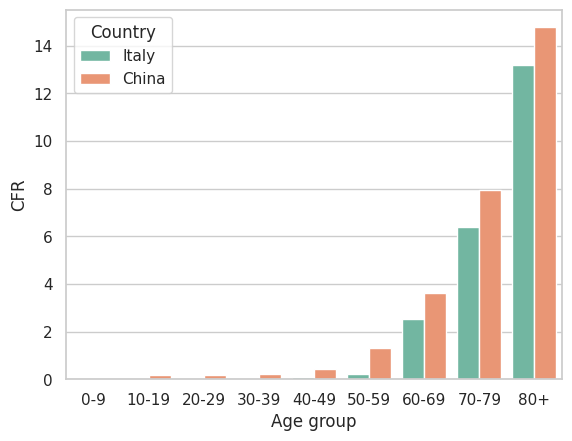

In [ ]:
sns.barplot(data=covid[covid['Country'].isin(['Italy', 'China'])], x="Age group", y="CFR", hue="Country")

Теперь рассчитайте общую CFR на основе суммарного количества случаев по всем возрастным категориями и сравните их для этих двух стран.

In [ ]:
cfr_italy = covid[covid['Country'] =='Italy']['Confirmed fatalities'].sum() / covid[covid['Country'] =='Italy']['Confirmed cases'].sum() * 100
cfr_china = covid[covid['Country'] =='China']['Confirmed fatalities'].sum() / covid[covid['Country'] =='China']['Confirmed cases'].sum() * 100

In [ ]:
cfr_total = pd.DataFrame({'Италия': cfr_italy, 'Китай': cfr_china}, index=['CFR общий'])
cfr_total

,Италия,Китай
CFR общий,4.448044,2.290025


Что можно наблюдать?

парадокс Симпсона, по гистограмме получаем в каждой из групп лидерство Китая, но суммарно Италия почти в два раза больше, у Китая в разы больше выборки, в этом эксперименте возраст сильно влияет на результат поэтому смешивать группы не верно, у Италии наибольшие численно группы - люди наибольшего возраста, в то время как у Китая - среднего и мало людей сильно пожилого возраста,

итого выделяем две причины: несравнимые размеры подгрупп и неправильное использование причинно-следственной связи, а именно молодые складываются с пожилыми (изначально такое соотношение подтвержденных случаев между возрастными группами между странами мб обусловлено более высокой долей пожилого населения в Италии, чем в Китае)

**2.** Итак, мы исследуем три признака: страна, возрастная категория, CFR. Определите на них граф причинно-следственных связей на основе логических соображений и визуализируйте его.

In [ ]:
causal_graph = nx.DiGraph([
    ('Country', 'CFR'),
    ('Age group', 'CFR'),
    ('Country', 'Age group'),
])

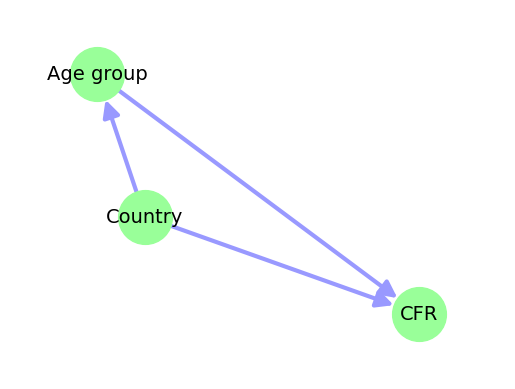

In [ ]:
draw_graph(causal_graph, options)

Для каждой вершины опишите характер причинно-следственной связи. Например, если это линейная регрессия, то надо *выписать ее формулу*.

получаем что cfr - таргет cfr ~ age group + country; country - кофаундер

In [ ]:
causal_model = gcm.StructuralCausalModel(causal_graph)
gcm.auto.assign_causal_mechanisms(causal_model, covid)

gcm.fit(causal_model, covid)

Fitting causal mechanism of node Age group: 100%|██████████| 3/3 [00:00<00:00, 138.33it/s]


In [ ]:
model_T = causal_model.causal_mechanism('Age group')
model_Y = causal_model.causal_mechanism('CFR')
model_X = causal_model.causal_mechanism('Country')

model_T, model_Y, model_X

(Classifier FCM based on LogisticRegression(max_iter=10000),
 <dowhy.gcm.stochastic_models.EmpiricalDistribution at 0x7c06b9ffaad0>)

In [ ]:
sklearn_model = model_Y.prediction_model.sklearn_model
sklearn_model.coef_, sklearn_model.intercept_

(array([1.08333333, 1.11111111]), -5.929001595172433)

CFR = 1.08333333 * Age group + 1.11111111 * Country - 5.929001595172433

**3.** Сделаем две копии признака "страна":
* `demography` ($D$) &mdash; демографическая ситуация, определяемая страной;
* `treatment methods` ($T$) &mdash; методы лечения, свойственные стране.

Мы делаем такое разделение потому как, например, одна страна может взять методы лечения другой страны, но демографическую ситуацию поменять при этом не получится.

Визуализируйте причинно-следственный граф с новыми признаками вместо `Country`.

In [ ]:
covid['demography'] = covid['Country']
covid['treatment methods'] = covid['Country']

In [ ]:
causal_graph = nx.DiGraph([
    ('demography', 'Age group'),
    ('treatment methods', 'CFR'),
    ('Age group', 'CFR')
])

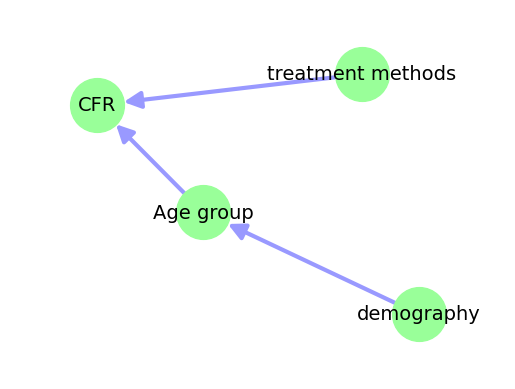

In [ ]:
draw_graph(causal_graph, options)

Определите по графу causal модель и обучите ее

In [ ]:
causal_model = gcm.StructuralCausalModel(causal_graph)
gcm.auto.assign_causal_mechanisms(causal_model, covid)

gcm.fit(causal_model, covid)

Fitting causal mechanism of node CFR: 100%|██████████| 4/4 [00:00<00:00, 128.23it/s]


С помощью интервенции оцените, было бы эффективнее в Китае с его демографической ситуацией применять итальянские методы лечения. Для этого нужно оценить величину
$$NDE = \mathsf{E}(CFR\ |\ D:=China, T:=Italy) - \mathsf{E}(CFR\ |\ D:=China, T:=China),$$
где NDE &mdash; Natural Direct Effect. Используйте достаточно большое количество семплирований.

In [ ]:
num_samples_to_draw = 1_000_000

In [ ]:
%%time
NDE = gcm.average_causal_effect(causal_model,
                                'CFR',
                                interventions_alternative={'demography': lambda x: 'China', 'treatment methods': lambda x: 'Italy'}, # условие интервенции альтернативного эксперимента
                                interventions_reference={'demography': lambda x: 'China','treatment methods': lambda x: 'China'}, # условие интервенции референсного эксперимента
                                num_samples_to_draw=num_samples_to_draw)

NDE

CPU times: user 18.8 s, sys: 900 ms, total: 19.7 s
Wall time: 19.5 s


-0.689046132872877

Теперь, наоборот, оцените, было бы эффективнее применять в Италии с ее демографической ситуацией китайские методы лечения.

In [ ]:
%%time
NDE = gcm.average_causal_effect(causal_model,
                                'CFR',
                                interventions_alternative={'demography': lambda x: 'Italy', 'treatment methods': lambda x: 'China'}, # условие интервенции альтернативного эксперимента
                                interventions_reference={'demography': lambda x: 'Italy','treatment methods': lambda x: 'Italy'}, # условие интервенции референсного эксперимента
                                num_samples_to_draw=num_samples_to_draw)

NDE

CPU times: user 17.8 s, sys: 975 ms, total: 18.7 s
Wall time: 18.5 s


0.7008811908979102

Наконец, оценим, что было бы, если в Китае с его методами лечения демографическая ситуация была бы такой же, как в Италии (Natural Indirect Effect). Какую величину при этом надо рассчитать? Рассчитайте ее.

надо рассчитать $$NIE = \mathsf{E}(CFR\ |\ D:=Italy, T:=China) - \mathsf{E}(CFR\ |\ D:=China, T:=China),$$

In [ ]:
%%time
NIE = gcm.average_causal_effect(causal_model,
                                'CFR',
                                interventions_alternative={'demography': lambda x: 'Italy', 'treatment methods': lambda x: 'China'}, # условие интервенции альтернативного эксперимента
                                interventions_reference={'demography': lambda x: 'China','treatment methods': lambda x: 'China'}, # условие интервенции референсного эксперимента
                                num_samples_to_draw=num_samples_to_draw)

NIE

CPU times: user 17.8 s, sys: 892 ms, total: 18.7 s
Wall time: 18.5 s


-0.005709017204505784

Можно также получить доверительный интервал оценки эффекта с помощью `gcm.confidence_intervals`, но, так как данный метод принимает только функции без параметров в качестве аргумента, нужно либо задать дополнительно вспомогательную функцию `def f(): return target_f(*args, **kwargs)`, либо передать `lambda`-функцию без параметров.

КИТАЙ

In [ ]:
# для Китая
def calculate_NDE():
    NDE = gcm.average_causal_effect(causal_model,
                                    'CFR',
                                    interventions_alternative={'demography': lambda x: 'China', 'treatment methods': lambda x: 'Italy'},
                                    interventions_reference={'demography': lambda x: 'China', 'treatment methods': lambda x: 'China'},
                                    num_samples_to_draw=num_samples_to_draw)
    return NDE

def calculate_NIE():
    NIE = gcm.average_causal_effect(
                                  causal_model,
                                  'CFR',
                                  interventions_alternative={'demography': lambda x: 'Italy', 'treatment methods': lambda x: 'China'},
                                  interventions_reference={'demography': lambda x: 'China', 'treatment methods': lambda x: 'China'},
                                  num_samples_to_draw=num_samples_to_draw)
    return NIE

NDE_confidence_interval = gcm.confidence_intervals(
    lambda: calculate_NDE(),
    confidence_level=0.95
)

NIE_confidence_interval = gcm.confidence_intervals(
    lambda: calculate_NIE(),
    confidence_level=0.95
)
conf = pd.DataFrame({'NDE': [calculate_NDE(),  NDE_confidence_interval[1]], 'NIE': [calculate_NIE(), NIE_confidence_interval[1]]}, index=['value', '95% CI'])
conf

Estimating bootstrap interval...: 100%|██████████| 20/20 [06:26<00:00, 19.33s/it]


,NDE,NIE
value,-0.696613,0.007283
95% CI,"[[-0.7058387830230626, -0.672849023686941]]","[[-0.01951156349737717, 0.016786570789019354]]"


Повторите аналогичный эксперимент для Италии: если бы в этой стране применяли итальянские методы лечения, но демография была бы как в Китае.

In [ ]:
%%time
NIE = gcm.average_causal_effect(causal_model,
                                'CFR',
                                interventions_alternative={'demography': lambda x: 'China', 'treatment methods': lambda x: 'Italy'}, # условие интервенции альтернативного эксперимента
                                interventions_reference={'demography': lambda x: 'Italy','treatment methods': lambda x: 'Italy'}, # условие интервенции референсного эксперимента
                                num_samples_to_draw=num_samples_to_draw)

NIE

CPU times: user 19.9 s, sys: 736 ms, total: 20.6 s
Wall time: 20.5 s


0.024607561332526284

In [ ]:
# для Италии
def calculate_NDE():
    NDE = gcm.average_causal_effect(causal_model,
                                    'CFR',
                                    interventions_alternative={'demography': lambda x: 'Italy', 'treatment methods': lambda x: 'China'},
                                    interventions_reference={'demography': lambda x: 'Italy', 'treatment methods': lambda x: 'Italy'},
                                    num_samples_to_draw=num_samples_to_draw)
    return NDE

def calculate_NIE():
    NIE = gcm.average_causal_effect(
                                  causal_model,
                                  'CFR',
                                  interventions_alternative={'demography': lambda x: 'China', 'treatment methods': lambda x: 'Italy'},
                                  interventions_reference={'demography': lambda x: 'Italy', 'treatment methods': lambda x: 'Italy'},
                                  num_samples_to_draw=num_samples_to_draw)
    return NIE

NDE_confidence_interval = gcm.confidence_intervals(
    lambda: calculate_NDE(),
    confidence_level=0.95
)

NIE_confidence_interval = gcm.confidence_intervals(
    lambda: calculate_NIE(),
    confidence_level=0.95
)

print('Италия')
conf = pd.DataFrame({'NDE': [calculate_NDE(),  NDE_confidence_interval[1]], 'NIE': [calculate_NIE(), NIE_confidence_interval[1]]}, index=['value', '95% CI'])
conf

Estimating bootstrap interval...: 100%|██████████| 20/20 [06:24<00:00, 19.22s/it]


Италия


,NDE,NIE
value,0.675747,0.0022
95% CI,"[[0.672580031004678, 0.708869316060405]]","[[-0.018760033580096067, 0.026230787833959893]]"


**Выводы:** по NDE видно (положительный или отрицательный), что для Италии китайские методы лечения лучше (NDE=0.7), а для Китая итальянские - хуже(NDE=-0.69), а NIE около 0, поэтому Италии можно рекомендовать менять методы лечения на начальном этапе

**4.** Наконец, сравните между собой некоторые другие страны на ваш выбор. Каким странам вы рекомендовали бы поменять методы лечения на начальном этапе?

In [ ]:
covid['Country'].unique()

array(['Italy', 'Argentina', 'China', 'Colombia', 'Diam. Princ.',
       'Netherlands', 'Portugal', 'South Africa', 'Spain', 'Sweden',
       'Switzerland', 'South Korea'], dtype=object)

Швеция и Колумбия

In [ ]:
conf = pd.DataFrame({'Sweden': [gcm.average_causal_effect(causal_model,
                                'CFR',
                                interventions_alternative={'demography': lambda x: 'Sweden', 'treatment methods': lambda x: 'Colombia'}, # условие интервенции альтернативного эксперимента
                                interventions_reference={'demography': lambda x: 'Sweden','treatment methods': lambda x: 'Sweden'}, # условие интервенции референсного эксперимента
                                num_samples_to_draw=num_samples_to_draw),

                                gcm.average_causal_effect(causal_model,
                                'CFR',
                                interventions_alternative={'demography': lambda x: 'Colombia', 'treatment methods': lambda x: 'Sweden'}, # условие интервенции альтернативного эксперимента
                                interventions_reference={'demography': lambda x: 'Sweden','treatment methods': lambda x: 'Sweden'}, # условие интервенции референсного эксперимента
                                num_samples_to_draw=num_samples_to_draw)
                                ],
                     'Colombia': [gcm.average_causal_effect(causal_model,
                                'CFR',
                                interventions_alternative={'demography': lambda x: 'Colombia', 'treatment methods': lambda x: 'Sweden'}, # условие интервенции альтернативного эксперимента
                                interventions_reference={'demography': lambda x: 'Colombia','treatment methods': lambda x: 'Colombia'}, # условие интервенции референсного эксперимента
                                num_samples_to_draw=num_samples_to_draw),

                                gcm.average_causal_effect(causal_model,
                                'CFR',
                                interventions_alternative={'demography': lambda x: 'Sweden', 'treatment methods': lambda x: 'Colombia'}, # условие интервенции альтернативного эксперимента
                                interventions_reference={'demography': lambda x: 'Colombia','treatment methods': lambda x: 'Colombia'}, # условие интервенции референсного эксперимента
                                num_samples_to_draw=num_samples_to_draw)
                                ]},
                    index=['NDE', 'NIE'])
conf

,Sweden,Colombia
NDE,-0.856033,0.834195
NIE,-0.028211,-0.003694


Швейцария и Аргентина

In [ ]:
conf = pd.DataFrame({'Switzerland': [gcm.average_causal_effect(causal_model,
                                'CFR',
                                interventions_alternative={'demography': lambda x: 'Switzerland', 'treatment methods': lambda x: 'Argentina'}, # условие интервенции альтернативного эксперимента
                                interventions_reference={'demography': lambda x: 'Switzerland','treatment methods': lambda x: 'Switzerland'}, # условие интервенции референсного эксперимента
                                num_samples_to_draw=num_samples_to_draw),

                                gcm.average_causal_effect(causal_model,
                                'CFR',
                                interventions_alternative={'demography': lambda x: 'Argentina', 'treatment methods': lambda x: 'Switzerland'}, # условие интервенции альтернативного эксперимента
                                interventions_reference={'demography': lambda x: 'Switzerland','treatment methods': lambda x: 'Switzerland'}, # условие интервенции референсного эксперимента
                                num_samples_to_draw=num_samples_to_draw)
                                ],
                     'Argentina': [gcm.average_causal_effect(causal_model,
                                'CFR',
                                interventions_alternative={'demography': lambda x: 'Argentina', 'treatment methods': lambda x: 'Switzerland'}, # условие интервенции альтернативного эксперимента
                                interventions_reference={'demography': lambda x: 'Argentina','treatment methods': lambda x: 'Argentina'}, # условие интервенции референсного эксперимента
                                num_samples_to_draw=num_samples_to_draw),

                                gcm.average_causal_effect(causal_model,
                                'CFR',
                                interventions_alternative={'demography': lambda x: 'Switzerland', 'treatment methods': lambda x: 'Argentina'}, # условие интервенции альтернативного эксперимента
                                interventions_reference={'demography': lambda x: 'Argentina','treatment methods': lambda x: 'Argentina'}, # условие интервенции референсного эксперимента
                                num_samples_to_draw=num_samples_to_draw)
                                ]},
                    index=['NDE', 'NIE'])
conf

,Switzerland,Argentina
NDE,2.106986,-2.108245
NIE,-0.017806,0.004900


Испания и Португалия

In [ ]:
conf = pd.DataFrame({'Spain': [gcm.average_causal_effect(causal_model,
                                'CFR',
                                interventions_alternative={'demography': lambda x: 'Spain', 'treatment methods': lambda x: 'Portugal'}, # условие интервенции альтернативного эксперимента
                                interventions_reference={'demography': lambda x: 'Spain','treatment methods': lambda x: 'Spain'}, # условие интервенции референсного эксперимента
                                num_samples_to_draw=num_samples_to_draw),

                                gcm.average_causal_effect(causal_model,
                                'CFR',
                                interventions_alternative={'demography': lambda x: 'Portugal', 'treatment methods': lambda x: 'Spain'}, # условие интервенции альтернативного эксперимента
                                interventions_reference={'demography': lambda x: 'Spain','treatment methods': lambda x: 'Spain'}, # условие интервенции референсного эксперимента
                                num_samples_to_draw=num_samples_to_draw)
                                ],
                     'Portugal': [gcm.average_causal_effect(causal_model,
                                'CFR',
                                interventions_alternative={'demography': lambda x: 'Portugal', 'treatment methods': lambda x: 'Spain'}, # условие интервенции альтернативного эксперимента
                                interventions_reference={'demography': lambda x: 'Portugal','treatment methods': lambda x: 'Portugal'}, # условие интервенции референсного эксперимента
                                num_samples_to_draw=num_samples_to_draw),

                                gcm.average_causal_effect(causal_model,
                                'CFR',
                                interventions_alternative={'demography': lambda x: 'Spain', 'treatment methods': lambda x: 'Portugal'}, # условие интервенции альтернативного эксперимента
                                interventions_reference={'demography': lambda x: 'Portugal','treatment methods': lambda x: 'Portugal'}, # условие интервенции референсного эксперимента
                                num_samples_to_draw=num_samples_to_draw)
                                ]},
                    index=['NDE', 'NIE'])
conf

,Spain,Portugal
NDE,-0.843247,0.848813
NIE,-0.000354,-0.002003


Аргентина и Португалия

In [ ]:
conf = pd.DataFrame({'Argentina': [gcm.average_causal_effect(causal_model,
                                'CFR',
                                interventions_alternative={'demography': lambda x: 'Argentina', 'treatment methods': lambda x: 'Portugal'}, # условие интервенции альтернативного эксперимента
                                interventions_reference={'demography': lambda x: 'Argentina','treatment methods': lambda x: 'Argentina'}, # условие интервенции референсного эксперимента
                                num_samples_to_draw=num_samples_to_draw),

                                gcm.average_causal_effect(causal_model,
                                'CFR',
                                interventions_alternative={'demography': lambda x: 'Portugal', 'treatment methods': lambda x: 'Argentina'}, # условие интервенции альтернативного эксперимента
                                interventions_reference={'demography': lambda x: 'Argentina','treatment methods': lambda x: 'Argentina'}, # условие интервенции референсного эксперимента
                                num_samples_to_draw=num_samples_to_draw)
                                ],
                     'Portugal': [gcm.average_causal_effect(causal_model,
                                'CFR',
                                interventions_alternative={'demography': lambda x: 'Portugal', 'treatment methods': lambda x: 'Argentina'}, # условие интервенции альтернативного эксперимента
                                interventions_reference={'demography': lambda x: 'Portugal','treatment methods': lambda x: 'Portugal'}, # условие интервенции референсного эксперимента
                                num_samples_to_draw=num_samples_to_draw),

                                gcm.average_causal_effect(causal_model,
                                'CFR',
                                interventions_alternative={'demography': lambda x: 'Argentina', 'treatment methods': lambda x: 'Portugal'}, # условие интервенции альтернативного эксперимента
                                interventions_reference={'demography': lambda x: 'Portugal','treatment methods': lambda x: 'Portugal'}, # условие интервенции референсного эксперимента
                                num_samples_to_draw=num_samples_to_draw)
                                ]},
                    index=['NDE', 'NIE'])
conf

,Argentina,Portugal
NDE,-2.975380,2.978662
NIE,0.002146,0.026627


**Выводы:** Аналогично Италии для Колумбии и Швейцарии, Португалии при их демографии и лечении страны-партнера (Швеции, Аргентины, Испании или Аргентины соответственно) NDE положительный, наблюдается положительный эффект, им рекомендуется поменять методы лечения на начальном этапе, причем наиболее яркий эффект у пары Аргентина-Португалия, NIE все еще в районе нуля